# Genomic Analysis of the DiGeorge Syndrome Region on Chromosome 22

### Introduction to DNA and Genetic Variations


**What is DNA?**

DNA (Deoxyribonucleic Acid) is the molecule that carries the genetic instructions used in the growth, development, functioning, and reproduction of all living organisms.
It is made up of two chains that wind around each other, resembling a spiral staircase in the shape of a helix. All of our genetic information is encoded in the sequence of the so-called “bases” (Adenine (A), Thymine (T), Cytosine (C) and Guanine (G)).

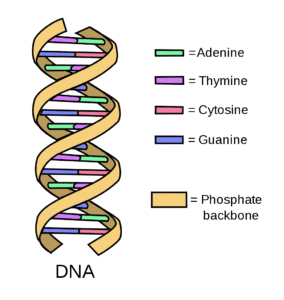

**What is a Chromosome?**

A chromosome is a long, organized structure of DNA and proteins found in cells. In humans, most cells contain 46 chromosomes, arranged in 23 pairs. Each chromosome is composed of a long DNA molecule, which is tightly coiled and packaged together with proteins to fit inside the nucleus of the cell.

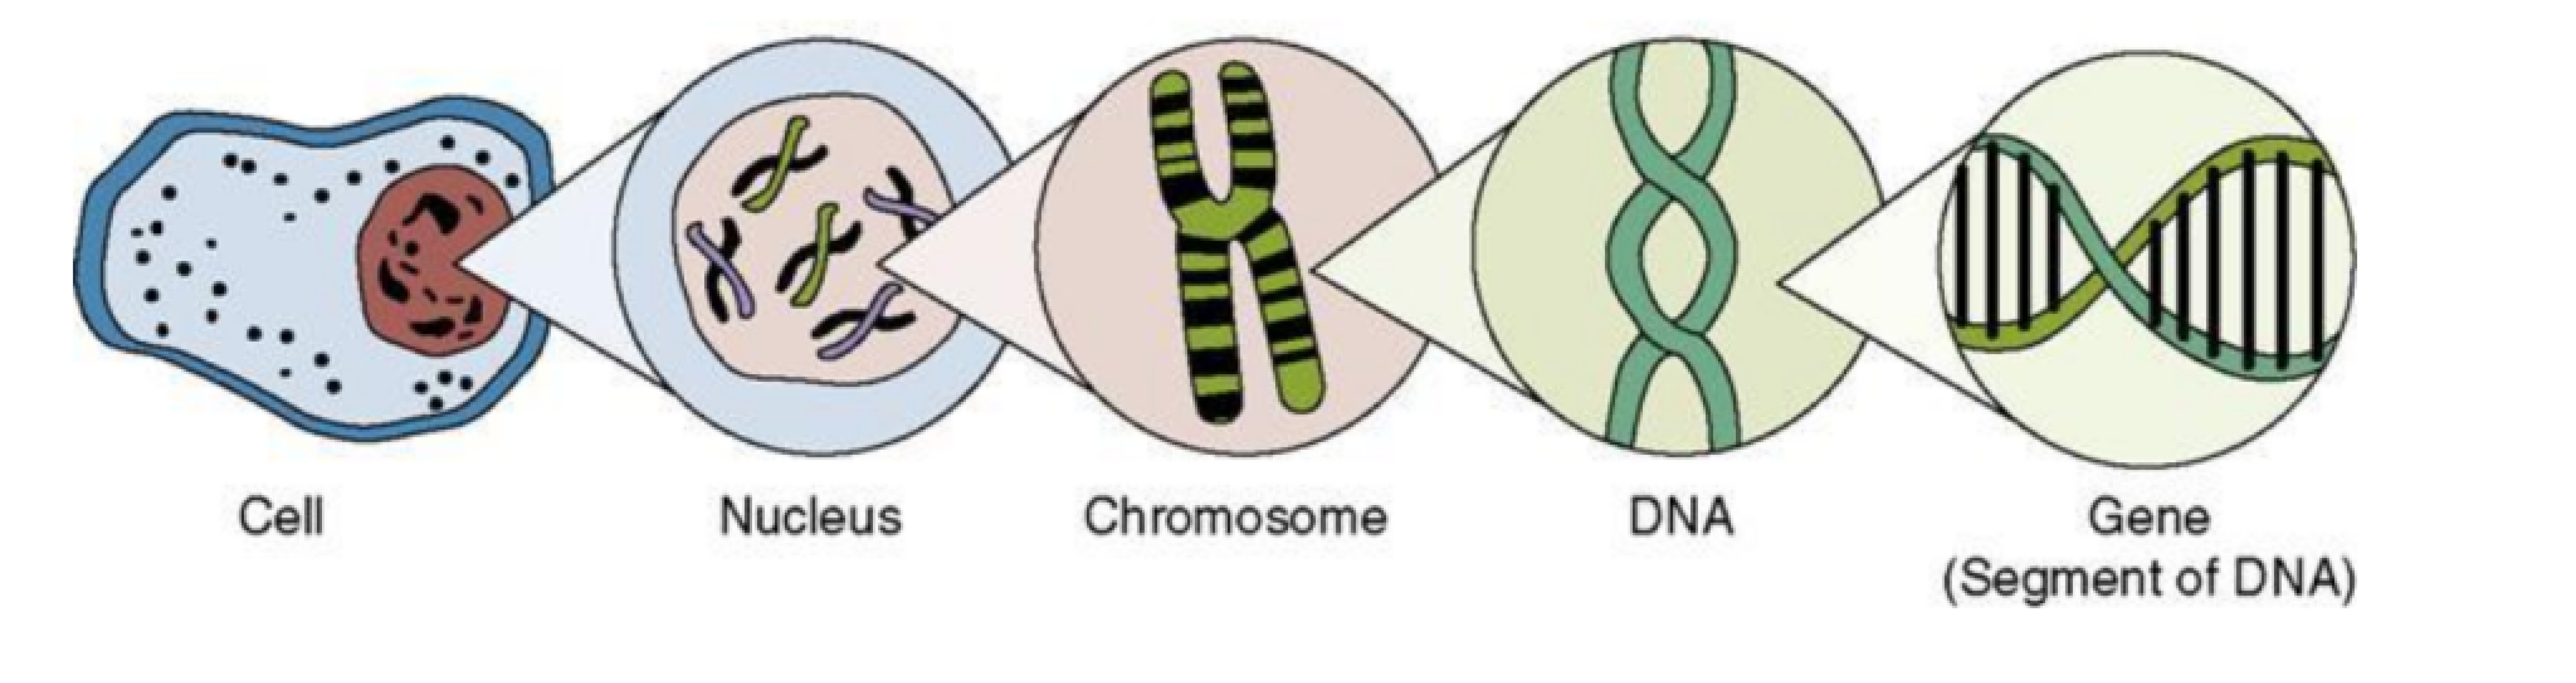

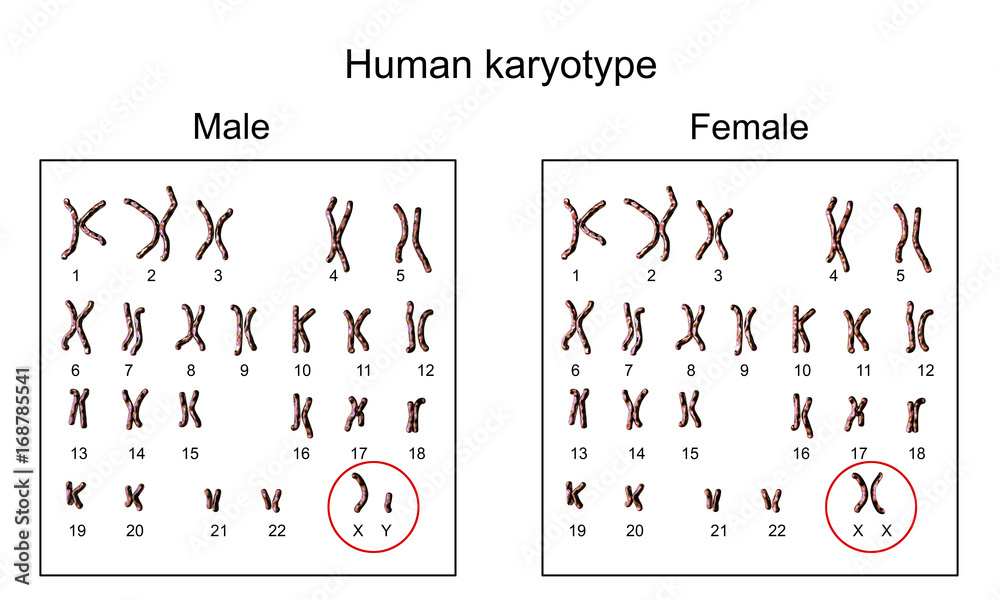

**Genetic Variations**:

While all humans share more than 99% of their DNA, small differences exist. These differences are known as genetic variations. They are defined by their size and mechanism of formation:

- Single Nucleotide Variants (SNVs): A change in a single base pair. These are the most common type of genetic variation, comprising ~80% of the differences betweentwo individuals.
- Insertions and Deletions (Indels): gain or loss of one or more nucleotides spanning <50 basepairs.
- Structural Variants (SVs): large-scale changes of the genome (>50 base pairs):
  - Copy Number Variants (CNVs): sections of the genome repeated or deleted, affecting the number of copies of a particular gene.
  - Inversions or insertions
  - Translocations



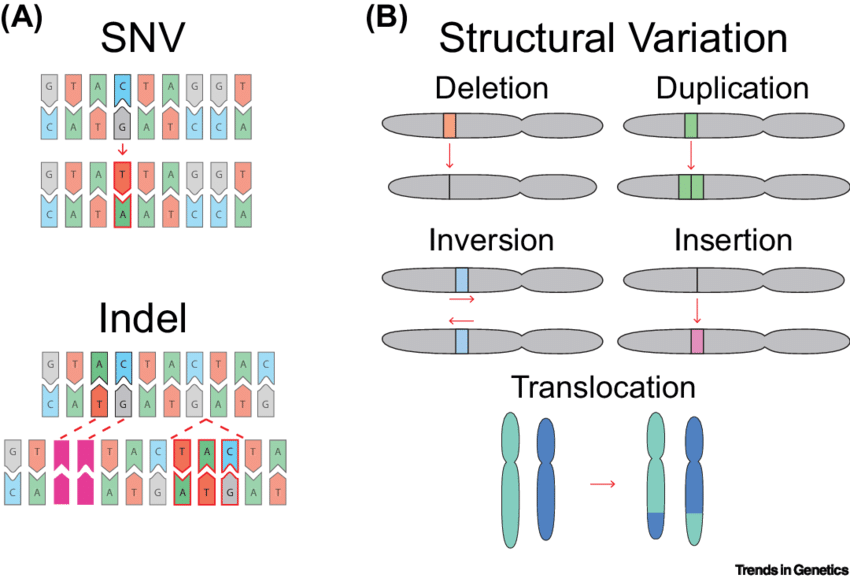

**Impact of Variations**:

While many genetic variations have no noticeable effect, others contribute to differences in traits such as eye color, height, or other physical characteristics. However, some variations are associated with an increased risk of developing certain diseases or health conditions. For example, the deletion of a specific segment on chromosome 22 is linked to DiGeorge Syndrome.

### DiGeorge Syndrome

DiGeorge Syndrome, also known as 22q11.2 deletion syndrome, is a genetic disorder caused by a deletion of a small segment on chromosome 22, located between positions 18,800,000 and 21,400,000, that is critical for normal development. Deletions in this region can lead to a range of symptoms, including heart defects, immune system abnormalities, and developmental delays.



**The 1000 Genomes Project**:

The 1000 Genomes Project is an international collaboration aimed at creating the most detailed catalog of human genetic variation. By sequencing the genomes of over 2,500 individuals from different populations around the world, the project provides a comprehensive resource for studying genetic diversity and its implications for human health.



**Hypothesis**:

The hypothesis is that pathogenic variants of the TBX1 gene show significant differences in prevalence among populations. Given TBX1's role in genetic disorders like 22q11.2 deletion syndrome, it is reasonable to investigate whether certain populations have a higher frequency of these variants, which may suggest increased genetic susceptibility.
Exploring this hypothesis is valuable for identifying potential differences in predisposition to TBX1-related conditions among population groups. This can guide future studies, inform public health interventions, and provide insights useful for personalized medicine.

## Step 1: Environment Setup and Data Loading

In this section, I configure the computational environment required to handle large genomic datasets.

### Step 1.1: Installing Dependencies

To begin working with the genomic data, I need to ensure that all necessary libraries and tools are installed. This includes tools for handling large datasets (such as PySpark) and various bioinformatics utilities that will assist us in processing and analyzing the genomic variants.


In [165]:
# Import necessary libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import requests
import numpy as np

# Install pyspark 3.3.2
!pip install pyspark==3.3.2
from pyspark.sql.functions import explode, col

# Set up the environment for Spark and other necessary tools
# Install Java 11 (compatible with Spark 3.3.2)
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Configure Spark environment variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.10/dist-packages/pyspark"


In [166]:
# Download libraries from Hadoop and AWS
!wget -q https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-aws/3.3.1/hadoop-aws-3.3.1.jar
!wget -q https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk-bundle/1.12.374/aws-java-sdk-bundle-1.12.374.jar

# Move libraries to Spark directory
!mv hadoop-aws-3.3.1.jar $SPARK_HOME/jars/
!mv aws-java-sdk-bundle-1.12.374.jar $SPARK_HOME/jars/


#### BioPerl: Tools for Bioinformatics in Perl

**BioPerl** is a collection of Perl modules designed to facilitate the development of bioinformatics applications. These modules provide tools for common tasks in biological data processing, such as:

- **Sequence Manipulation**: Reading, writing, and converting between different sequence formats (FASTA, GenBank, EMBL, etc.).
- **Sequence Analysis**: Performing alignments, pattern searches, and handling annotations.
- **Access to Biological Databases**: Interacting with public databases like GenBank, SwissProt, and PDB, making it easier to download and process biological data.
- **Structure Handling**: Support for handling protein and nucleic acid structures.

In [167]:
# Install Perl and necessary dependencies
!apt-get update
!apt-get install -y libxml2-dev libexpat1-dev libssl-dev libgd-dev libncurses5-dev zlib1g-dev libbz2-dev \
liblzma-dev libmysqlclient-dev libcurl4-openssl-dev build-essential

# Install cpanminus and BioPerl
!apt-get install -y cpanminus
!cpanm Bio::Perl

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 129 kB in 2s (79.1 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (

### Step 1.2: Configure Spark


In [127]:
from pyspark.sql import SparkSession
# Initiate Spark Session with detailed configuration
spark = SparkSession.builder \
    .appName("1000Genomes") \
    .config("spark.jars.packages",
            "org.apache.hadoop:hadoop-aws:3.3.6,"
            "com.amazonaws:aws-java-sdk-bundle:1.12.565,"
            "io.projectglow:glow-spark3_2.12:1.1.1") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

# Verify Spark session
print("Spark Session created:", spark)
print("Spark Version:", spark.version)
print("Spark App Name:", spark.sparkContext.appName)
print("Spark Master:", spark.sparkContext.master)

Spark Session created: <pyspark.sql.session.SparkSession object at 0x7dbbad4496c0>
Spark Version: 3.3.2
Spark App Name: 1000Genomes
Spark Master: local[*]



## Step 2: Load and filter the VCF Data

The data I'll work with comes from a VCF (Variant Call Format) file, which contains genomic variants for chromosome 22. This file includes key information such as the position of each variant, the type of variant (SNP, INDEL, structural variants), and the frequency of the alleles.

I'll first load the entire dataset and then filter it to focus on the region of chromosome 22 associated with DiGeorge Syndrome. This allows us to narrow our analysis to the region most relevant for the syndrome, ensuring that our findings are biologically meaningful.


In [128]:
# Define the file paths
vcf_url = "https://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20130502/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz"
vcf_gz_path = "/content/output.vcf.gz"
vcf_path = "/content/output.vcf"

try:
    # Check if the VCF file has already been downloaded
    if not os.path.exists(vcf_path):
        print("VCF file not found, downloading...")
        !wget -q -O {vcf_gz_path} {vcf_url}

        # Unzip VCF file if the download was successful
        if os.path.exists(vcf_gz_path):
            print("Unzipping VCF file...")
            !gunzip {vcf_gz_path}
        else:
            raise FileNotFoundError(f"Downloaded file {vcf_gz_path} was not found.")

    else:
        print("VCF file already exists, skipping download and extraction.")

except Exception as e:
    print(f"An error occurred: {e}")

VCF file already exists, skipping download and extraction.


Lets see the dataframe structure:

In [129]:
vcf_path = "/content/output.vcf"
vcf_df = spark.read.format("vcf").load(vcf_path)

vcf_df.show(10)

+----------+--------+--------+--------------------+---------------+--------------------+-----+-------+---------------------+---------+----------------+----------+-------+--------------------+-------+-------+------------------+--------------------+----------+-------+--------------------+--------------------+--------------------+-------+----------+---------+-----------+--------------+-------+-------+--------+-----------+--------------------+--------------+--------+-----------+--------------------+
|contigName|   start|     end|               names|referenceAllele|    alternateAlleles| qual|filters|splitFromMultiAllelic|INFO_MEND|         INFO_AC|INFO_CIEND|INFO_NS|         INFO_AFR_AF|INFO_VT|INFO_AN|INFO_MULTI_ALLELIC|         INFO_SAS_AF|INFO_CIPOS|INFO_AA|             INFO_AF|         INFO_EAS_AF|         INFO_AMR_AF|INFO_DP|INFO_SVLEN|INFO_MLEN|INFO_MEINFO|INFO_IMPRECISE|INFO_CS|INFO_MC|INFO_END|INFO_MSTART|         INFO_EUR_AF|INFO_EX_TARGET|INFO_TSD|INFO_SVTYPE|           genotypes

In [130]:
#Understand the dataset schema
vcf_df.printSchema()

root
 |-- contigName: string (nullable = true)
 |-- start: long (nullable = true)
 |-- end: long (nullable = true)
 |-- names: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- referenceAllele: string (nullable = true)
 |-- alternateAlleles: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- qual: double (nullable = true)
 |-- filters: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- splitFromMultiAllelic: boolean (nullable = true)
 |-- INFO_MEND: integer (nullable = true)
 |-- INFO_AC: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- INFO_CIEND: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- INFO_NS: integer (nullable = true)
 |-- INFO_AFR_AF: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- INFO_VT: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- INFO_AN: integer (nullable = true)
 |-- INF

The dataset has multiple columns. Below I detail the most relevant columns in this analysis:
- contigName: The name of the chromosome, in this case "22".
- start and end: Start and end positions of the variant in the chromosome.
- referenceAllele: The reference sequence in the genome that is replaced or modified by the variant.
- alternateAlleles: List of variants of the reference sequence.
- INFO_AF: Allele frequency of the variant in the general population.
- INFO_AFR_AF, INFO_EUR_AF, INFO_SAS_AF, INFO_AMR_AF, INFO_EAS_AF: Allele frequency of the variant in specific populations: African (AFR), European (EUR), South Asian (SAS), American (AMR) and East Asian (EAS).
- INFO_VT: Type of variant.
- INFO_SVTYPE: Specifies the type of structural variant.

In [131]:
#Count rows to know the number of variants
vcf_df.count()

1103547

In [132]:
# Count the number of variants by type
variant_counts = vcf_df.groupBy("INFO_VT").count().show()

+------------+-------+
|     INFO_VT|  count|
+------------+-------+
|[SNP, INDEL]|    871|
|       [SNP]|1059517|
|        [SV]|    782|
|     [INDEL]|  42377|
+------------+-------+



- 1,059,517 variants are SNP.

- 42,377 variants are Indels.

- 782 are SVs.

- 871 variants are identified as both SNPs and INDELs, which may indicate a complex variant or multiple annotations. These variants could behave as either type depending on the genomic context.

In [133]:
#Remove compressed files to free memory
vcf_gz_path = '/content/output.vcf.gz'
if os.path.exists(vcf_gz_path):
    os.remove(vcf_gz_path)
    print(f"Deleted {vcf_gz_path} to free up space.")
else:
    print(f"{vcf_gz_path} does not exist.")

/content/output.vcf.gz does not exist.


I'm going to filter the data to keep only the region associated with DiGeorge disease.

In [134]:
# Filter the DataFrame for variants within the DiGeorge Syndrome region on chromosome 22
df_22q11 = vcf_df.filter(
    (vcf_df.start >= 18800000) &
    (vcf_df.start <= 21400000)
)

# Show the first few rows of the filtered annotated DataFrame
df_22q11.show(10)


+----------+--------+--------+-------------+---------------+----------------+-----+-------+---------------------+---------+-------+----------+-------+-----------+-------+-------+------------------+-----------+----------+-------+------------+-----------+-----------+-------+----------+---------+-----------+--------------+-------+-------+--------+-----------+-----------+--------------+--------+-----------+--------------------+
|contigName|   start|     end|        names|referenceAllele|alternateAlleles| qual|filters|splitFromMultiAllelic|INFO_MEND|INFO_AC|INFO_CIEND|INFO_NS|INFO_AFR_AF|INFO_VT|INFO_AN|INFO_MULTI_ALLELIC|INFO_SAS_AF|INFO_CIPOS|INFO_AA|     INFO_AF|INFO_EAS_AF|INFO_AMR_AF|INFO_DP|INFO_SVLEN|INFO_MLEN|INFO_MEINFO|INFO_IMPRECISE|INFO_CS|INFO_MC|INFO_END|INFO_MSTART|INFO_EUR_AF|INFO_EX_TARGET|INFO_TSD|INFO_SVTYPE|           genotypes|
+----------+--------+--------+-------------+---------------+----------------+-----+-------+---------------------+---------+-------+----------+--

## Step 3: Variant Analysis and Classification

After loading and filtering the VCF data, I'll proceed to classify the variants within the region of interest based on their type.

Understanding the distribution of these variant types is crucial for identifying potential genetic markers associated with DiGeorge Syndrome. By grouping the variants by type, I can assess which types are most prevalent in this region and may have a higher likelihood of contributing to the genetic predisposition to the syndrome.


In [224]:
# Group by variant type and count the occurrences
df_22q11.groupBy("INFO_VT").count().show()

+------------+-----+
|     INFO_VT|count|
+------------+-----+
|[SNP, INDEL]|  213|
|       [SNP]|71081|
|        [SV]|   68|
|     [INDEL]| 3131|
+------------+-----+



The table above shows the distribution of variant types within the 22q11.2 region of chromosome 22:

- **SNPs** are the most common type of variant, with a total of 70,262 occurrences.
- **INDELs** are less frequent, with 2,766 variants.
- **SVs** occur 53 times.
- There are also 52 variants classified as both **SNP and INDEL**.

This distribution highlights that SNPs are by far the most prevalent variant type in this region, which is consistent with the general observation that SNPs are the most common type of genetic variation.

An allele is a specific type of genetic variant that affects a visible characteristic, or phenotype. The next table summarizes the allele frequencies (AF) of the variants in this region:

In [225]:
# Explode the 'INFO_AF' column and rename the exploded column to 'AlleleFreq'
df_22q11 = df_22q11.withColumn("AlleleFreq", explode(col("INFO_AF")))

# Describe allele frequencies
df_22q11.select("AlleleFreq").describe().show()

+-------+--------------------+
|summary|          AlleleFreq|
+-------+--------------------+
|  count|               76597|
|   mean|0.038425575125257294|
| stddev| 0.13392462606855554|
|    min|                 0.0|
|    max|                 1.0|
+-------+--------------------+





- **Count**: There are 73,567 alleles present in the dataset.
- **Mean**: The mean allele frequency is approximately 0.0372. This suggests that, on average, the alleles in this region are rare, as the mean is much lower than 0.5.
- **StdDev**: The standard deviation of 0.133 indicates a wide variation in allele frequencies, with many variants likely being extremely rare.
- **Min**: The minimum allele frequency is 0, which suggests that some variants are not present in the population.
- **Max**: The maximum allele frequency is 1, meaning that certain variants are present in all individuals sampled.

This data suggests that most of the variants in this region are rare, which is typical for regions associated with genetic disorders. Rare variants often have a higher impact on disease phenotypes, making them important targets for further analysis.



### Visualize the Allele Frequency Distribution

I'll use a histogram to visualize the distribution of allele frequencies, which will allow us to determine if most rare variants have low frequencies, as expected, or if there is significant variability in their distribution.

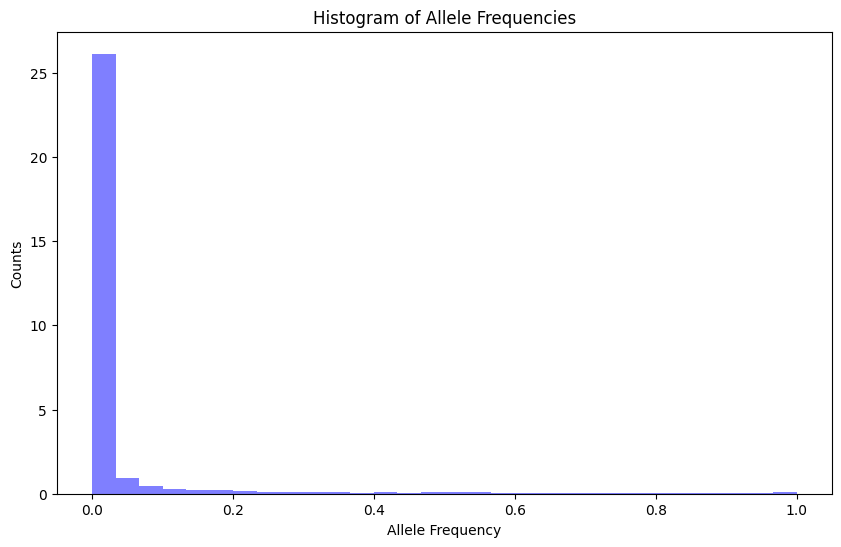

In [226]:
# Convert the DataFrame to a Pandas DataFrame for easier plotting
allele_freqs = df_22q11.select("AlleleFreq").toPandas()

# Plot a histogram of allele frequencies
plt.figure(figsize=(10, 6))
plt.hist(allele_freqs, bins=30, density=True, alpha=0.5, color='blue')
plt.title('Histogram of Allele Frequencies')
plt.xlabel('Allele Frequency')
plt.ylabel('Counts')
plt.show()

High Peak at Low Frequencies: As expected, most variants have frequencies close to 0, indicating that these variants are extremely rare in the population. These could represent rare variants that might have more significant impacts on individuals.

Sparse High-Frequency Variants: There are very few variants with higher allele frequencies, suggesting that most of the genetic variation in this region consists of rare variants.

## Step 4: Focus on Rare Variants

In this section, I further filter the variants in the 22q11.2 region by focusing on rare variants, defined as those with an allele frequency below 0.05. This threshold allows us to isolate the variants that are less common in the population but may have significant effects on disease susceptibility.

**`INFO_VT`** and **`INFO_SVTYPE`** columns categorize the type of structural variation (e.g., deletions, duplications, insertions), helping to identify the nature of the genomic change.


In [227]:
# Filter the DataFrame to obtain only rare variants (allele frequency < 0.05).
# This is important because rare variants often have a higher impact on genetic diseases.
rare_variants_df = df_22q11.filter(df_22q11["AlleleFreq"] < 0.05)

# Show the first 10 rows of the filtered DataFrame to verify that the filter was applied correctly.
rare_variants_df.show(10)

+----------+--------+--------+-------------+---------------+----------------+-----+-------+---------------------+---------+-------+----------+-------+-----------+-------+-------+------------------+-----------+----------+-------+------------+-----------+-----------+-------+----------+---------+-----------+--------------+-------+-------+--------+-----------+-----------+--------------+--------+-----------+--------------------+----------+
|contigName|   start|     end|        names|referenceAllele|alternateAlleles| qual|filters|splitFromMultiAllelic|INFO_MEND|INFO_AC|INFO_CIEND|INFO_NS|INFO_AFR_AF|INFO_VT|INFO_AN|INFO_MULTI_ALLELIC|INFO_SAS_AF|INFO_CIPOS|INFO_AA|     INFO_AF|INFO_EAS_AF|INFO_AMR_AF|INFO_DP|INFO_SVLEN|INFO_MLEN|INFO_MEINFO|INFO_IMPRECISE|INFO_CS|INFO_MC|INFO_END|INFO_MSTART|INFO_EUR_AF|INFO_EX_TARGET|INFO_TSD|INFO_SVTYPE|           genotypes|AlleleFreq|
+----------+--------+--------+-------------+---------------+----------------+-----+-------+---------------------+---------

In [228]:
# Group by SVs
rare_variants_df.groupBy('INFO_VT',"INFO_SVTYPE").count().show()

+------------+-----------+-----+
|     INFO_VT|INFO_SVTYPE|count|
+------------+-----------+-----+
|[SNP, INDEL]|       null|  326|
|       [SNP]|       null|65183|
|     [INDEL]|       null| 2534|
|        [SV]|        CNV|   40|
|        [SV]|        DUP|    9|
|        [SV]|        DEL|   30|
|        [SV]|        ALU|    2|
|        [SV]|        SVA|    1|
|        [SV]|      LINE1|    1|
|        [SV]|        INS|    1|
+------------+-----------+-----+



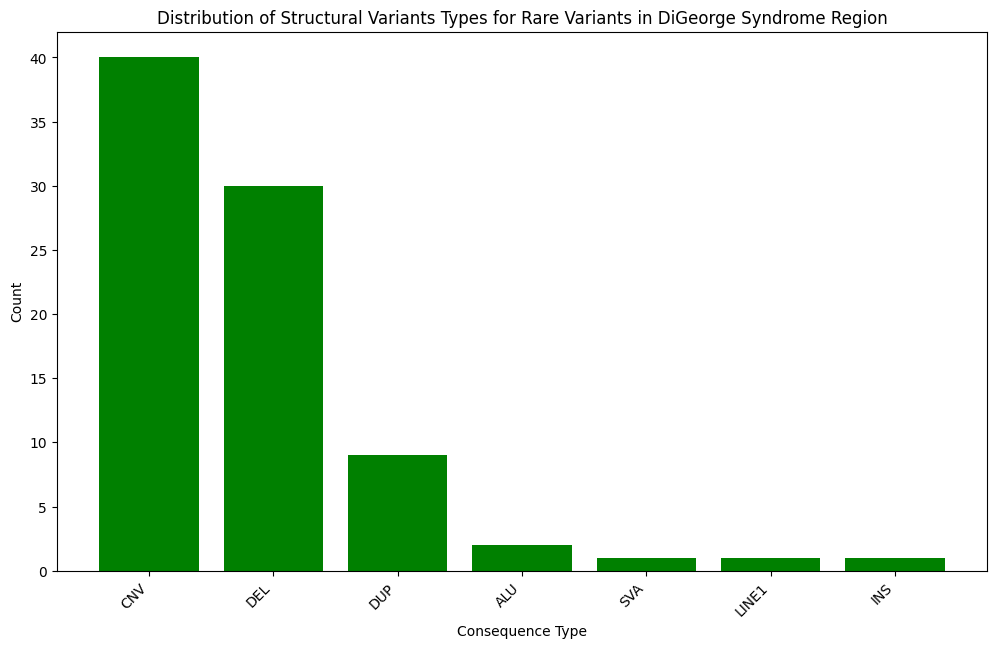

In [229]:
consequence_counts = rare_variants_df.groupBy("INFO_SVTYPE").count().orderBy("count", ascending=False)
consequence_counts = consequence_counts.dropna(subset=["INFO_SVTYPE"])
labels, values = zip(*consequence_counts.collect())

#Barplot
plt.figure(figsize=(12, 7))
plt.bar(labels, values, color='green')
plt.title('Distribution of Structural Variants Types for Rare Variants in DiGeorge Syndrome Region')
plt.xlabel('Consequence Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha="right")
plt.show()

#Free memory
consequence_counts = None
labels = None
values = None

The tables and bar chart above show the distribution of structural variation types among rare variants in the 22q11.2 region.
The most common type of structural variation is DEL (deletions), with 30 occurrences, which is consistent with the known association between large deletions in 22q11.2 and DiGeorge Syndrome. I also observe the presence of mobile elements like ALU, LINE1, and SVA, though their occurrence is quite low. These elements can disrupt normal gene function by inserting themselves into new genomic locations, contributing to genomic instability, which can be relevant to the pathology of DiGeorge Syndrome.


Now I'll plot a scatter plot to visualize the distribution of the rare variants. Each point in the scatter plot represents a variant, with its position on the x-axis corresponding to its location along the chromosome, and the y-axis representing the allele frequency of the variant. By plotting the variants in this way, I aim to observe any patterns in their distribution along the chromosome.

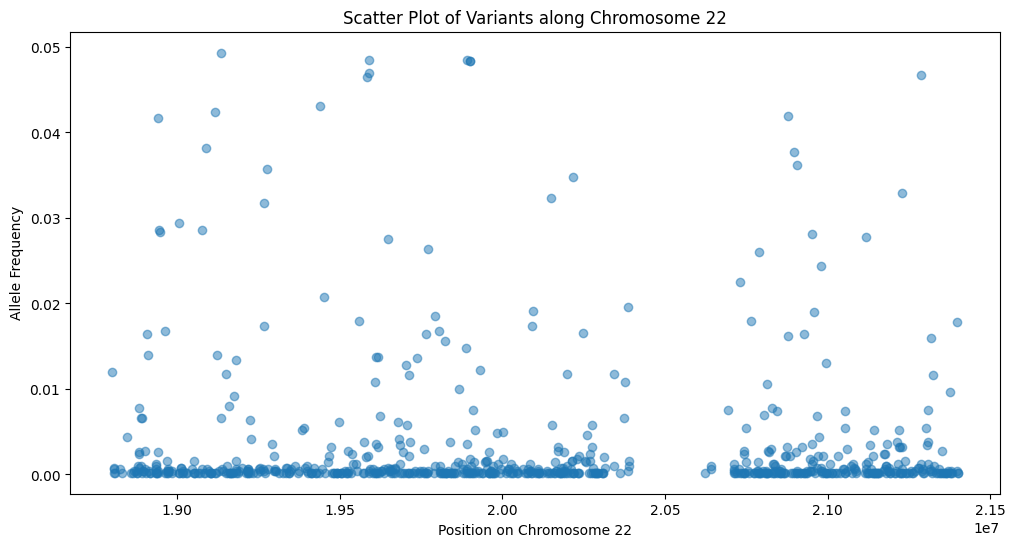

In [230]:
pos, allele_freqs = zip(*rare_variants_df.select("start", "AlleleFreq").sample(False, 0.01).collect())

plt.figure(figsize=(12, 6))
plt.scatter(pos, allele_freqs, alpha=0.5)
plt.title('Scatter Plot of Variants along Chromosome 22')
plt.xlabel('Position on Chromosome 22')
plt.ylabel('Allele Frequency')
plt.show()

As expected, most variants have low allele frequencies. However, the plot also reveals clusters of variants with higher allele frequencies scattered throughout the region.

There are gaps in the distribution, which could suggest regions with fewer variants or regions that are not well covered in the dataset. These gaps may warrant further investigation to determine if they are biologically significant or simply due to limitations in the data.


### Population-Specific Allele Frequency Analysis

In this section, I will explore the distribution of allele frequencies for rare variants across different populations. By comparing the allele frequencies in various populations, I aim to identify patterns that may suggest population-specific genetic variations, which could be relevant for understanding genetic susceptibility to DiGeorge Syndrome.

The dataset provides allele frequency information for multiple populations, including:
- **African Population (INFO_AFR_AF)**
- **European Population (INFO_EUR_AF)**
- **South Asian Population (INFO_SAS_AF)**
- **American Population (INFO_AMR_AF)**
- **East Asian Population (INFO_EAS_AF)**

In [231]:
# Extract the first element from each array of allele frequencies
rare_variants_df = rare_variants_df.withColumn("AFR_AF", col("INFO_AFR_AF").getItem(0)) \
                                   .withColumn("EUR_AF", col("INFO_EUR_AF").getItem(0)) \
                                   .withColumn("SAS_AF", col("INFO_SAS_AF").getItem(0)) \
                                   .withColumn("AMR_AF", col("INFO_AMR_AF").getItem(0)) \
                                   .withColumn("EAS_AF", col("INFO_EAS_AF").getItem(0))

# Now, describe the allele frequencies statistics for each population
rare_variants_df.select("AFR_AF", "EUR_AF", "SAS_AF", "AMR_AF", "EAS_AF").describe().show()



+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|              AFR_AF|              EUR_AF|              SAS_AF|              AMR_AF|              EAS_AF|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  count|               68127|               68127|               68127|               68127|               68127|
|   mean|0.007532079792152611|0.003197743919444...|0.003957203458247077|0.003437123313810...|0.003472772909419168|
| stddev| 0.03168890545595541| 0.02873082915173187|0.030628243988295785|0.027910678130332496| 0.02885331719470818|
|    min|                 0.0|                 0.0|                 0.0|                 0.0|                 0.0|
|    max|              0.9902|                 1.0|                 1.0|              0.9986|                 1.0|
+-------+--------------------+--------------------+--------------------+--------

- **Count**: All columns contain 65,803 data points, indicating that the dataset is complete with no missing values for these populations.

- **Mean**:
  - The mean allele frequencies across populations are relatively low, ranging from 0.0018 (EUR_AF) to 0.0062 (AFR_AF). This suggests that, on average, most alleles in this dataset are rare in the populations studied.
  - The African population (AFR_AF) exhibits a higher mean allele frequency compared to other populations, which could indicate greater genetic diversity in the African population.

- **Standard Deviation (stddev)**:
  - The standard deviation is also relatively low but indicates variability in allele frequencies. Populations like AFR_AF and EAS_AF show slightly higher variability, which suggests a broader range of allele frequencies compared to the EUR_AF population, which shows lower variability.
  
- **Minimum (min)**:
  - The minimum value of 0.0 in all populations means that there are alleles absent (not present at all) in certain individuals or groups within each population.

- **Maximum (max)**:
  - The maximum allele frequency reaches values close to 1 in all populations, meaning that some alleles are nearly or completely fixed (present in all individuals) in those populations.
  - Interestingly, the maximum allele frequency in the AFR_AF population is slightly lower (0.9902) compared to the full 1.0 observed in EUR_AF, SAS_AF, and EAS_AF populations. This could reflect the greater genetic variation typically seen in African populations.


Given that the majority of allele frequencies are extremely low, it is challenging to interpret the data without additional filtering. To address this, I'll filter out variants with an allele frequency of 0 to focus on those that show variation between populations.

Doing this, I can better understand the distribution of rare variants that actually occur in the population, which might provide insights into population-specific genetic variations.


In [232]:
# Function to collect and filter allele frequencies
def get_filtered_freqs(population_column):
    freqs = [row[0] for row in rare_variants_df.select(population_column).dropna().collect()]
    return list(filter(lambda x: x > 0, freqs))

# Collect and filter frequencies for each population
afr_freqs_filtered = get_filtered_freqs("AFR_AF")
eur_freqs_filtered = get_filtered_freqs("EUR_AF")
sas_freqs_filtered = get_filtered_freqs("SAS_AF")
amr_freqs_filtered = get_filtered_freqs("AMR_AF")
eas_freqs_filtered = get_filtered_freqs("EAS_AF")

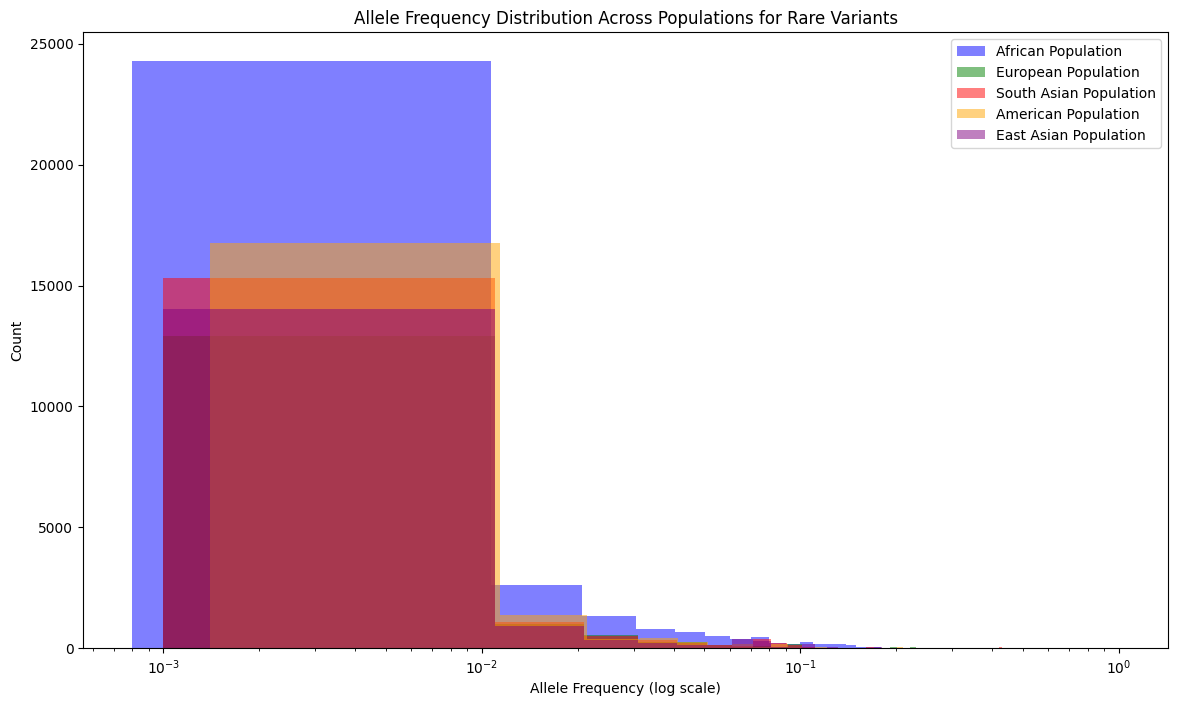

In [233]:
#Plot histograms
plt.figure(figsize=(14, 8))
plt.hist(afr_freqs_filtered, bins=100, alpha=0.5, label='African Population', color='blue')
plt.hist(eur_freqs_filtered, bins=100, alpha=0.5, label='European Population', color='green')
plt.hist(sas_freqs_filtered, bins=100, alpha=0.5, label='South Asian Population', color='red')
plt.hist(amr_freqs_filtered, bins=100, alpha=0.5, label='American Population', color='orange')
plt.hist(eas_freqs_filtered, bins=100, alpha=0.5, label='East Asian Population', color='purple')

plt.xscale('log')
plt.title('Allele Frequency Distribution Across Populations for Rare Variants')
plt.xlabel('Allele Frequency (log scale)')
plt.ylabel('Count')
plt.legend()
plt.show()


The histogram shows the distribution of allele frequencies for rare variants across five different populations: African, European, South Asian, American, and East Asian. After filtering out the variants with a frequency of 0, we can see that most rare variants still have very low frequencies, with the majority clustering in the range of 10⁻³ to 10⁻² across all populations.

The African population (violet) appears to have the highest number of variants with slightly higher allele frequencies, suggesting that there might be more variation in this population compared to others. The South Asian and American populations also show some frequency peaks, while the European and East Asian populations show fewer rare variants with higher frequencies.

This distribution reflects the fact that rare variants are mostly population-specific and tend to be uncommon across multiple populations. The slight differences in frequency distributions between populations may point to unique genetic adaptations or demographic histories.


A boxplot will provide a clear visual comparison of allele frequencies between populations. This way, I can see how the African (or other) population compares in terms of dispersion and median to the others.

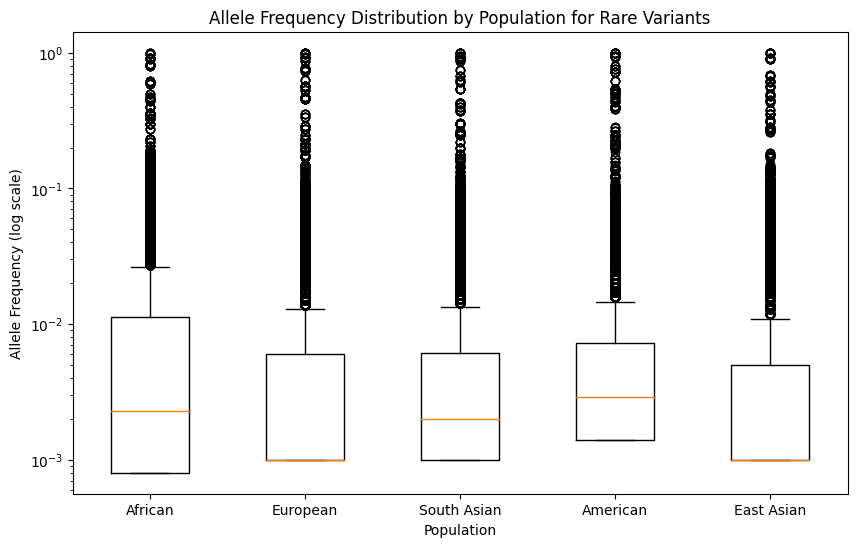

In [234]:
# Plot Boxplot
data = [afr_freqs_filtered, eur_freqs_filtered, sas_freqs_filtered, amr_freqs_filtered, eas_freqs_filtered]
labels = ['African', 'European', 'South Asian', 'American', 'East Asian']

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels)
plt.yscale('log')
plt.title('Allele Frequency Distribution by Population for Rare Variants')
plt.ylabel('Allele Frequency (log scale)')
plt.xlabel('Population')
plt.show()


1. African population:
The African population shows the greatest dispersion in allele frequencies, suggesting greater genetic diversity compared to the other populations. The box and the "whiskers" of the boxplot are wider, indicating greater variability in allele frequencies.
The median in Africa is also higher, indicating that many rare variants have a relatively high frequency in this population, reinforcing the hypothesis that alleles are more established in Africa due to its greater genetic diversity.

2. American population:
Although not as dispersed as the African population, the median in the American population is also relatively high compared to other non-African populations. This suggests that a significant portion of rare variants have relatively high allele frequencies in this region.
This could be explained by the history of admixture in the Americas, where the admixture of African, European and Native populations has contributed to a greater stability of certain genetic variants.

3. Other populations (European, South Asian, East Asian):
These populations show lower dispersion and lower median allele frequencies. This suggests that rare variants in these regions are less frequent in the general population, which is in line with the evolutionary history of these regions, which experienced a genetic "bottleneck", reducing their genetic diversity.

4. Outliers:
All populations show a significant number of outliers, indicating that there are rare variants that have particularly high allele frequencies in some individuals or specific subpopulations.

## Step 5: TBX1 Gene

DiGeorge syndrome is associated with a deletion in the 22q11.2 region, which houses several key genes involved in human development. Among them, the TBX1 gene has been identified as a primary contributor to the characteristic symptoms of this syndrome, especially in the development of the heart, palate, and thymus. However, other genes within this region, such as COMT, CRKL, HIRA, and MAPK1, may also play a role in the variability and severity of symptoms due to their functions in various cellular and developmental processes. Given the particular importance of TBX1 in the clinical presentation of DiGeorge syndrome, I decided to focus my analysis on this gene.

In this final section, I will analyze the variants located within the TBX1 gene region. By examining the frequency and distribution of these variants, I could gain insights into whether certain populations may have a higher prevalence of specific TBX1 variants, potentially affecting their susceptibility to DiGeorge Syndrome symptoms.

### Filter TBX1 gene section

In [235]:
# Filter variants in the position range of the TBX1 gene
tbx1_variants_df = rare_variants_df.filter((col("contigName") == "22") &
                                           (col("start") >= 19334474) &
                                           (col("end") <= 19368639))
tbx1_variants_df.show(5)


+----------+--------+--------+-------------+---------------+----------------+-----+-------+---------------------+---------+-------+----------+-------+-----------+-------+-------+------------------+-----------+----------+-------+------------+-----------+-----------+-------+----------+---------+-----------+--------------+-------+-------+--------+-----------+-----------+--------------+--------+-----------+--------------------+----------+------+------+------+------+------+
|contigName|   start|     end|        names|referenceAllele|alternateAlleles| qual|filters|splitFromMultiAllelic|INFO_MEND|INFO_AC|INFO_CIEND|INFO_NS|INFO_AFR_AF|INFO_VT|INFO_AN|INFO_MULTI_ALLELIC|INFO_SAS_AF|INFO_CIPOS|INFO_AA|     INFO_AF|INFO_EAS_AF|INFO_AMR_AF|INFO_DP|INFO_SVLEN|INFO_MLEN|INFO_MEINFO|INFO_IMPRECISE|INFO_CS|INFO_MC|INFO_END|INFO_MSTART|INFO_EUR_AF|INFO_EX_TARGET|INFO_TSD|INFO_SVTYPE|           genotypes|AlleleFreq|AFR_AF|EUR_AF|SAS_AF|AMR_AF|EAS_AF|
+----------+--------+--------+-------------+--------

Summary of allele frequencies of TBX1 variants by population to get an overview of how these variants are distributed:

In [236]:
# Describe allele frequencies in TBX1 by population
tbx1_variants_df.select("AFR_AF", "EUR_AF", "SAS_AF", "AMR_AF", "EAS_AF").describe().show()


+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|              AFR_AF|              EUR_AF|              SAS_AF|              AMR_AF|              EAS_AF|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  count|                 903|                 903|                 903|                 903|                 903|
|   mean|0.003445182724252487|0.001391251384274...|0.002235326688815...|0.001877740863787377|0.001667884828349...|
| stddev|0.012211419020093988|0.007236707432482...| 0.01326513707076704|0.007335117562645429|0.009343014314156097|
|    min|                 0.0|                 0.0|                 0.0|                 0.0|                 0.0|
|    max|              0.0915|              0.1352|              0.1616|               0.098|              0.1161|
+-------+--------------------+--------------------+--------------------+--------

The African population appears to have a higher genetic diversity in terms of rare variants in TBX1, as it presents the highest average allele frequency of these variants.
European and Asian populations show some specific variants that are relatively more frequent compared to other variants in TBX1, which is reflected in their peak frequencies.

I will extract information on TBX1 variants across the different populations.

In [237]:
# Show some of the variants in TBX1 and their frequencies by population
allec_frec_geozone = tbx1_variants_df.select("start", "end", "referenceAllele", "alternateAlleles", "AFR_AF", "EUR_AF", "SAS_AF", "AMR_AF", "EAS_AF", 'INFO_VT')
allec_frec_geozone.show(10)

+--------+--------+---------------+----------------+------+------+------+------+------+-------+
|   start|     end|referenceAllele|alternateAlleles|AFR_AF|EUR_AF|SAS_AF|AMR_AF|EAS_AF|INFO_VT|
+--------+--------+---------------+----------------+------+------+------+------+------+-------+
|19334506|19334507|              G|             [T]|   0.0|   0.0|0.0051|   0.0|   0.0|  [SNP]|
|19334522|19334523|              C|             [T]|   0.0| 0.001|   0.0|   0.0|   0.0|  [SNP]|
|19334523|19334524|              C|             [T]|   0.0|   0.0| 0.001|   0.0|   0.0|  [SNP]|
|19334576|19334577|              G|             [A]|8.0E-4|   0.0|   0.0|   0.0|   0.0|  [SNP]|
|19334627|19334628|              G|             [A]|0.0061|   0.0|   0.0|   0.0|   0.0|  [SNP]|
|19334667|19334668|              A|             [G]|   0.0|   0.0|   0.0|   0.0| 0.004|  [SNP]|
|19334681|19334682|              C|             [T]|   0.0| 0.003|0.0133|   0.0|   0.0|  [SNP]|
|19334840|19334841|              C|     

### ClinVar DB and Pathogenicity

ClinVar is a public database that collects information about genetic variants and their association with clinical conditions. I will use ClinVar to obtain details about variants in the TBX1 gene, specifically those classified as pathogenic. Through queries to their API, I will extract data on the genomic position of the variants, as well as their clinical significance, associated condition, and variant type.

In [238]:
def fetch_clinvar_pathogenic_variants():
    # This function retrieves a list of variant IDs associated with the TBX1 gene from ClinVar.

    # Set the URL for the ClinVar search endpoint
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"

    # Define the parameters for the API request:
    # - "db": specifies the ClinVar database
    # - "term": searches for variants linked to the TBX1 gene
    # - "retmode": requests the response in JSON format
    # - "retmax": limits the maximum number of results returned to 2000
    params = {
        "db": "clinvar",
        "term": "TBX1[Gene]",
        "retmode": "json",
        "retmax": "2000"
    }

    # Send the GET request to ClinVar with the specified parameters
    response = requests.get(url, params=params)

    # Check if the request was successful (HTTP status code 200)
    if response.status_code == 200:
        # Parse the response JSON to obtain the list of variant IDs
        data = response.json()
        id_list = data["esearchresult"]["idlist"]
        return id_list  # Return the list of variant IDs
    else:
        # Print an error message if the request was unsuccessful
        print("Error in ClinVar query")
        return []  # Return an empty list if there was an error

# Get the list of variant IDs for TBX1
variant_ids = fetch_clinvar_pathogenic_variants()
print(f"{len(variant_ids)} pathogenic variants for TBX1 found in ClinVar")

1352 pathogenic variants for TBX1 found in ClinVar


In [239]:
def fetch_variant_details(variant_ids):
    # This function retrieves detailed information for a list of ClinVar variant IDs.

    # Set the URL for the ClinVar summary endpoint
    details_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"

    # Initialize an empty list to store the details for each variant
    variant_details = []

    # Process the variant IDs in batches of 100 to avoid URL length issues
    for i in range(0, len(variant_ids), 100):
        # Get the current batch of up to 100 variant IDs
        batch_ids = variant_ids[i:i + 100]

        # Send the GET request to the ClinVar summary endpoint for this batch
        details_response = requests.get(details_url, params={
            "db": "clinvar",
            "id": ",".join(batch_ids),
            "retmode": "json"
        })

        # Check if the request was successful
        if details_response.status_code == 200:
            # Parse the JSON response
            details_data = details_response.json()

            # Iterate through the results for each variant ID
            for variant_id in details_data["result"]:
                if variant_id != "uids":  # Ignore metadata entry "uids"
                    # Get data for the specific variant
                    variant = details_data["result"][variant_id]
                    variation = variant.get("variation_set", [{}])[0]
                    variation_loc = variation.get("variation_loc", [])

                    # Check for positions in GRCh38 and GRCh37
                    # Use "Unknown" if the position data is missing
                    position_grch38 = variation_loc[0].get("start", "Unknown") if len(variation_loc) > 0 else "Unknown"
                    position_grch37 = variation_loc[1].get("start", "Unknown") if len(variation_loc) > 1 else "Unknown"

                    # Append the details of the variant to the list
                    variant_details.append({
                        "variant_id": variant_id,
                        "title": variant.get("title", "Unknown"),
                        "chromosome": variation_loc[0].get("chr", "Unknown") if variation_loc else "Unknown",
                        "position_grch38": position_grch38,
                        "position_grch37": position_grch37,
                        "clinical_significance": variant.get("germline_classification", {}).get("description", "Unknown"),
                        "condition": variant.get("germline_classification", {}).get("trait_set", [{}])[0].get("trait_name", "Unknown"),
                        "variant_type": variation.get("variant_type", "Unknown")
                    })
        else:
            # Print an error message if the request failed for this batch
            print(f"Error getting details for batch IDs: {batch_ids}")

    # Convert the list of variant details into a DataFrame and return it
    return pd.DataFrame(variant_details)

In [240]:
# Get variant details for TBX1
clinvar_tbx1_df = fetch_variant_details(variant_ids)

#I drop the rows that do not have information in the columns position_grch37 and position_grch38
clinvar_tbx1_df = clinvar_tbx1_df[~((clinvar_tbx1_df['position_grch37'] == 'Unknown') & (clinvar_tbx1_df['position_grch38'] == 'Unknown'))].reset_index(drop=True)


In [241]:
#I transform the 'Unknown' values ​​to NaNs for the columns position_grch37 y position_grch38
clinvar_tbx1_df["position_grch37"] = pd.to_numeric(clinvar_tbx1_df["position_grch37"].replace("Unknown", np.nan), errors='coerce')
clinvar_tbx1_df["position_grch38"] = pd.to_numeric(clinvar_tbx1_df["position_grch38"].replace("Unknown", np.nan), errors='coerce')

#### Calculate the grch37 position from grch38 to avoid loss of information

The 1000 Genomes Project data is aligned to the GRCh37 reference, while more recent databases and annotations, like ClinVar, often use the updated GRCh38 reference. However, the GRCh37 positions in ClinVar contain several NaN values, which would result in information loss if I relied solely on this reference. To avoid losing data, I'll use the LiftOver tool to predict the GRCh37 positions from the available GRCh38 coordinates and fill in missing values.

In [242]:
# Create a DataFrame with the GRCh38 positions and a temporary ID
positions_df = clinvar_tbx1_df[["position_grch38", "position_grch37"]].copy()
# Delete rows without position_grch38
positions_df = positions_df.dropna(subset=["position_grch38"])
positions_df["chromosome"] = "chr22"
positions_df["start"] = positions_df["position_grch38"].astype(int) - 1  # LiftOver uses start position 0
positions_df["end"] = positions_df["position_grch38"].astype(int)
positions_df["id"] = positions_df.index  # Temporary ID to re-identify the rows
positions_df["id"] = positions_df["id"].astype(int)

# Export
positions_df[["chromosome", "start", "end", "id"]].to_csv("positions_grch38.bed", sep="\t", header=False, index=False)


In [243]:
# Load the file with the converted LiftOver positions
liftover_df = pd.read_csv("positions_grch37_liftover.bed", sep="\t", header=None, usecols=[0, 1, 2, 3], names=["chromosome", "start", "end", "id"])
liftover_df.head()

,chromosome,start,end,id
0,chr22,19747078,19747079,0
1,chr22,19753425,19753426,1
2,chr22,19750858,19750859,2
3,chr22,19748672,19748673,3
4,chr22,19754285,19754286,4


In [244]:
# Convert `start` to 1-based to align with GRCh37 in ClinVar
liftover_df["position_grch37_liftover"] = liftover_df["start"] + 1

# Create an `id` column in `clinvar_tbx1_df` based on the index
clinvar_tbx1_df["id"] = clinvar_tbx1_df.index.astype(int)

# Concatenate the column `position_grch37_liftover` to the original DataFrame `clinvar_tbx1_df`
clinvar_tbx1_df = clinvar_tbx1_df.merge(liftover_df[["id", "position_grch37_liftover"]], on="id", how="left")
clinvar_tbx1_df.dropna(subset=["position_grch37_liftover"], inplace=True)
clinvar_tbx1_df.drop(columns=["id"], inplace=True)
clinvar_tbx1_df

,variant_id,title,chromosome,position_grch38,position_grch37,clinical_significance,condition,variant_type,position_grch37_liftover
0,3361057,NM_080647.1(TBX1):c.-86-2A>G,22,19759556,19747079.0,Uncertain significance,not provided,single nucleotide variant,19747079.0
1,3356920,NM_001379200.1(TBX1):c.937C>T (p.Pro313Ser),22,19765903,19753426.0,Uncertain significance,TBX1-related disorder,single nucleotide variant,19753426.0
2,3351074,NM_001379200.1(TBX1):c.533G>A (p.Arg178His),22,19763336,19750859.0,Uncertain significance,TBX1-related disorder,single nucleotide variant,19750859.0
3,3347293,NM_001379200.1(TBX1):c.307G>T (p.Ala103Ser),22,19761150,19748673.0,Uncertain significance,TBX1-related disorder,single nucleotide variant,19748673.0
4,3345036,NM_001379200.1(TBX1):c.1417_1455del (p.Ala473_...,22,19766763,19754286.0,Uncertain significance,TBX1-related disorder,Deletion,19754286.0
...,...,...,...,...,...,...,...,...,...
1343,7567,NM_001379200.1(TBX1):c.609C>G (p.His203Gln),22,19764224,19751747.0,Pathogenic,Velocardiofacial syndrome,single nucleotide variant,19751747.0
1344,7566,NM_001379200.1(TBX1):c.1326_1348del (p.Pro444fs),22,19766672,19754195.0,Pathogenic,Velocardiofacial syndrome,Deletion,19754195.0
1345,7565,NM_001379200.1(TBX1):c.1250del (p.Ser417fs),22,19766602,19754125.0,Pathogenic,Conotruncal anomaly face syndrome,Deletion,19754125.0
1346,7564,NM_001379200.1(TBX1):c.955G>A (p.Gly319Ser),22,19765921,19753444.0,Benign,not provided,single nucleotide variant,19753444.0


In [245]:
#Crear la columna `position_grch37_merged` en `clinvar_tbx1_df`
clinvar_tbx1_df["position_grch37_merged"] = clinvar_tbx1_df["position_grch37"].combine_first(clinvar_tbx1_df["position_grch37_liftover"])
clinvar_tbx1_df["position_grch37_merged"] = clinvar_tbx1_df["position_grch37_merged"].astype(int)
clinvar_tbx1_df.head()

,variant_id,title,chromosome,position_grch38,position_grch37,clinical_significance,condition,variant_type,position_grch37_liftover,position_grch37_merged
0,3361057,NM_080647.1(TBX1):c.-86-2A>G,22,19759556,19747079.0,Uncertain significance,not provided,single nucleotide variant,19747079.0,19747079
1,3356920,NM_001379200.1(TBX1):c.937C>T (p.Pro313Ser),22,19765903,19753426.0,Uncertain significance,TBX1-related disorder,single nucleotide variant,19753426.0,19753426
2,3351074,NM_001379200.1(TBX1):c.533G>A (p.Arg178His),22,19763336,19750859.0,Uncertain significance,TBX1-related disorder,single nucleotide variant,19750859.0,19750859
3,3347293,NM_001379200.1(TBX1):c.307G>T (p.Ala103Ser),22,19761150,19748673.0,Uncertain significance,TBX1-related disorder,single nucleotide variant,19748673.0,19748673
4,3345036,NM_001379200.1(TBX1):c.1417_1455del (p.Ala473_...,22,19766763,19754286.0,Uncertain significance,TBX1-related disorder,Deletion,19754286.0,19754286


### Merge the information of the DBs

In [246]:
#Explode allec_frec_geozone column INFO_TV
allec_frec_geozone = allec_frec_geozone.withColumn("INFO_VT", explode(col("INFO_VT")))
allec_frec_geozone.show(5)

+--------+--------+---------------+----------------+------+------+------+------+------+-------+
|   start|     end|referenceAllele|alternateAlleles|AFR_AF|EUR_AF|SAS_AF|AMR_AF|EAS_AF|INFO_VT|
+--------+--------+---------------+----------------+------+------+------+------+------+-------+
|19334506|19334507|              G|             [T]|   0.0|   0.0|0.0051|   0.0|   0.0|    SNP|
|19334522|19334523|              C|             [T]|   0.0| 0.001|   0.0|   0.0|   0.0|    SNP|
|19334523|19334524|              C|             [T]|   0.0|   0.0| 0.001|   0.0|   0.0|    SNP|
|19334576|19334577|              G|             [A]|8.0E-4|   0.0|   0.0|   0.0|   0.0|    SNP|
|19334627|19334628|              G|             [A]|0.0061|   0.0|   0.0|   0.0|   0.0|    SNP|
+--------+--------+---------------+----------------+------+------+------+------+------+-------+
only showing top 5 rows



In [247]:
allec_frec_geozone = allec_frec_geozone.toPandas().copy()
allec_frec_geozone.INFO_VT.value_counts()

,count
INFO_VT,
SNP,885
INDEL,25
SV,1


In [280]:
# Convert list columns to strings
allec_frec_geozone["referenceAllele"] = allec_frec_geozone["referenceAllele"].apply(lambda x: str(x) if isinstance(x, list) else x)
allec_frec_geozone["alternateAlleles"] = allec_frec_geozone["alternateAlleles"].apply(lambda x: str(x) if isinstance(x, list) else x)

# Filter out SV and INDEL type variants and remove duplicates
variants = allec_frec_geozone[(allec_frec_geozone.INFO_VT == 'SV') | (allec_frec_geozone.INFO_VT == 'INDEL')].drop_duplicates(subset=["start", "end", "referenceAllele", "alternateAlleles"]).reset_index(drop=True)
variants


,start,end,referenceAllele,alternateAlleles,AFR_AF,EUR_AF,SAS_AF,AMR_AF,EAS_AF,INFO_VT
0,19336454,19336457,CAT,['C'],0.0166,0.0000,0.0000,0.0014,0.0000,INDEL
1,19337683,19337690,TCCATCA,['T'],0.0008,0.0060,0.0010,0.0043,0.0000,INDEL
2,19341084,19341087,TAC,['T'],0.0053,0.0000,0.0000,0.0043,0.0000,INDEL
3,19341781,19341783,CT,['C'],0.0015,0.0050,0.0225,0.0014,0.0000,INDEL
4,19344228,19344236,CCCCTCAG,['C'],0.0000,0.0000,0.0225,0.0000,0.0000,INDEL
5,19344403,19344405,GC,['G'],0.0008,0.0209,0.0164,0.0058,0.0000,INDEL
6,19345511,19345512,A,['AG'],0.0121,0.0000,0.0000,0.0014,0.0000,INDEL
7,19347310,19347312,GC,['G'],0.0023,0.0000,0.0000,0.0000,0.0000,INDEL
8,19355654,19355655,C,['CAG'],0.0000,0.0000,0.0051,0.0000,0.0000,INDEL
9,19355806,19355809,CAA,['C'],0.0038,0.0000,0.0010,0.0000,0.0000,INDEL


The following plot shows the distribution of INDEL and SV variants along the TBX1 gene region. Each mark on the genomic position axis represents a variant, allowing us to observe areas with a higher concentration of variants. This visualization is useful for identifying specific regions that may be relevant in studies on susceptibility to DiGeorge syndrome.

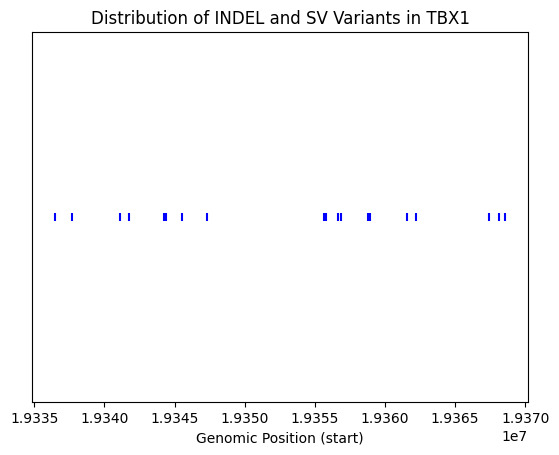

In [281]:
# Plot positions of INDEL and SV variants
plt.scatter(variants["start"], [1] * len(variants), marker='|', color='blue')
plt.xlabel("Genomic Position (start)")
plt.title("Distribution of INDEL and SV Variants in TBX1")
plt.yticks([])
plt.show()


The plot displays the distribution of INDEL and SV variants in the TBX1 gene, revealing that these variants are not uniformly distributed. Instead, there are several clusters of variants at certain genomic positions. The presence of these clusters suggests specific regions within TBX1 with higher structural variability. This concentration of variants in particular areas could be significant for studies on disease susceptibility or gene functionality, especially if some of these variants exhibit frequency differences across populations.

Finally, I will associate each variant found in the 1000 Genomes dataset with the closest position in ClinVar to determine its clinical significance. This approach allows for identifying potential clinical relevance, even if exact positional matches are not present in ClinVar. By finding the nearest ClinVar positions, I aim to capture clinically relevant insights that might otherwise be missed due to slight positional differences between datasets.

In [282]:
# Create a list to store distance, clinical condition, and ClinVar variant ID
closest_conditions = []

# Iterate over each position in variants dataframe
for index, row in variants.iterrows():
    start_pos = row["start"]

    # Calculate the distance between the start and all positions in ClinVar
    clinvar_tbx1_df["distance"] = abs(clinvar_tbx1_df["position_grch37_merged"] - start_pos)

    # Find the row in clinvar_tbx1_df with the smallest distance to start_pos
    closest_variant = clinvar_tbx1_df.loc[clinvar_tbx1_df["distance"].idxmin()]

    # Store distance, condition and variant ID in the list
    closest_conditions.append({
        "start": start_pos,
        "closest_clinvar_position": closest_variant["position_grch37_merged"],
        "distance": closest_variant["distance"],
        "clinical_significance": closest_variant["clinical_significance"],
    })
    #Drop distance column
    clinvar_tbx1_df.drop(columns=["distance"], inplace=True)

# Convert the list to a DataFrame and merge it with variants to add the information
closest_conditions_df = pd.DataFrame(closest_conditions)
closest_conditions_df.head()

,start,closest_clinvar_position,distance,clinical_significance
0,19336454,19324121,12333,Pathogenic
1,19337683,19324121,13562,Pathogenic
2,19341084,19324121,16963,Pathogenic
3,19341781,19324121,17660,Pathogenic
4,19344228,19324121,20107,Pathogenic


In [283]:
variants = variants.merge(closest_conditions_df, on="start", how="left")
variants

,start,end,referenceAllele,alternateAlleles,AFR_AF,EUR_AF,SAS_AF,AMR_AF,EAS_AF,INFO_VT,closest_clinvar_position,distance,clinical_significance
0,19336454,19336457,CAT,['C'],0.0166,0.0000,0.0000,0.0014,0.0000,INDEL,19324121,12333,Pathogenic
1,19337683,19337690,TCCATCA,['T'],0.0008,0.0060,0.0010,0.0043,0.0000,INDEL,19324121,13562,Pathogenic
2,19341084,19341087,TAC,['T'],0.0053,0.0000,0.0000,0.0043,0.0000,INDEL,19324121,16963,Pathogenic
3,19341781,19341783,CT,['C'],0.0015,0.0050,0.0225,0.0014,0.0000,INDEL,19324121,17660,Pathogenic
4,19344228,19344236,CCCCTCAG,['C'],0.0000,0.0000,0.0225,0.0000,0.0000,INDEL,19324121,20107,Pathogenic
5,19344403,19344405,GC,['G'],0.0008,0.0209,0.0164,0.0058,0.0000,INDEL,19324121,20282,Pathogenic
6,19345511,19345512,A,['AG'],0.0121,0.0000,0.0000,0.0014,0.0000,INDEL,19324121,21390,Pathogenic
7,19347310,19347312,GC,['G'],0.0023,0.0000,0.0000,0.0000,0.0000,INDEL,19324121,23189,Pathogenic
8,19355654,19355655,C,['CAG'],0.0000,0.0000,0.0051,0.0000,0.0000,INDEL,19324121,31533,Pathogenic
9,19355806,19355809,CAA,['C'],0.0038,0.0000,0.0010,0.0000,0.0000,INDEL,19324121,31685,Pathogenic


When associating the structural variants in the 1000 Genomes dataset with ClinVar, they were all linked to the same variant in ClinVar at a close position, even though the distances vary significantly. This association may indicate a lack of specific variants in ClinVar to accurately represent the diversity of INDELs and structural variants in the TBX1 gene in the 1000 Genomes dataset. The variability in distances suggests that many of these associations are not particularly relevant in terms of proximity. To improve this analysis, it would be ideal to have a clinical database that includes a greater diversity of variants, or to perform a variant annotation based on the genomic region, to identify areas of clinical relevance, rather than relying exclusively on associations.

To understand whether pathogenic TBX1 variants show significant differences in prevalence among populations, I'll calculate the the average frequency of these variants for each population group (AFR, EUR, SAS, AMR, EAS).
Additionally, an analysis of variance (ANOVA) test will be conducted to assess whether these differences in average allele frequencies are statistically significant. This analysis will help us evaluate if any population has a higher prevalence of pathogenic variants compared to others.

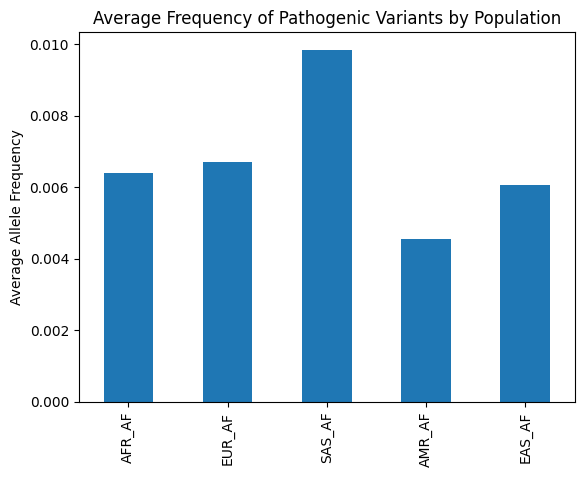

In [284]:
pathogenic_variants = variants[variants["clinical_significance"] == "Pathogenic"]
pathogenic_frequencies = pathogenic_variants[["AFR_AF", "EUR_AF", "SAS_AF", "AMR_AF", "EAS_AF"]].mean()
pathogenic_frequencies.plot(kind="bar")
plt.title("Average Frequency of Pathogenic Variants by Population")
plt.ylabel("Average Allele Frequency")
plt.show()

In [285]:
from scipy.stats import f_oneway

# Realizar ANOVA para comparar frecuencias alélicas entre las poblaciones
f_stat, p_value = f_oneway(
    pathogenic_variants["AFR_AF"].dropna(),
    pathogenic_variants["EUR_AF"].dropna(),
    pathogenic_variants["SAS_AF"].dropna(),
    pathogenic_variants["AMR_AF"].dropna(),
    pathogenic_variants["EAS_AF"].dropna()
)

print("ANOVA F-statistic:", f_stat)
print("ANOVA p-value:", p_value)

ANOVA F-statistic: 0.29639560912519086
ANOVA p-value: 0.8796040484757047


The results show that, although the average frequency of pathogenic variants in the SAS population is slightly higher compared to other populations, the statistical analysis (ANOVA) indicates that this difference is not significant (p-value = 0.88). This suggests that variations in the prevalence of pathogenic TBX1 variants among the different populations may be due to chance and do not represent a real difference. In conclusion, pathogenic variants in TBX1 appear to be relatively evenly distributed across the studied populations.

## Conclusions

In this project, I analyzed TBX1 gene variants using data from the 1000 Genomes and ClinVar datasets to explore their population distribution and clinical relevance. I started with the hypothesis that pathogenic TBX1 variants might show significant frequency differences across populations, which could suggest differential susceptibility to certain diseases.

I observed that African (AFR) and American (AMR) populations have a higher number of established variants, likely due to historical and evolutionary factors. Africa’s long-standing genetic diversity and admixture in the Americas seem to contribute to a broader genetic base in these regions.

The average frequency results for pathogenic variants across populations did not show significant differences (p-value = 0.88), suggesting a relatively even distribution of TBX1 pathogenic variants. This analysis highlights the need for more diverse and detailed clinical databases to effectively characterize variants across populations, with the potential to enhance personalized medicine approaches.